In [7]:
import numpy as np
from matplotlib import pyplot as plt
import math
import random
import pandas as pd
import scipy.stats as stats

# Calculating the CI

I want to check that I fully understand how confidence intervals are achieved and what they mean, for that I have results with a CI of 90% from an A/B tool, and I'll try to achieve the same values. This is the baseline:

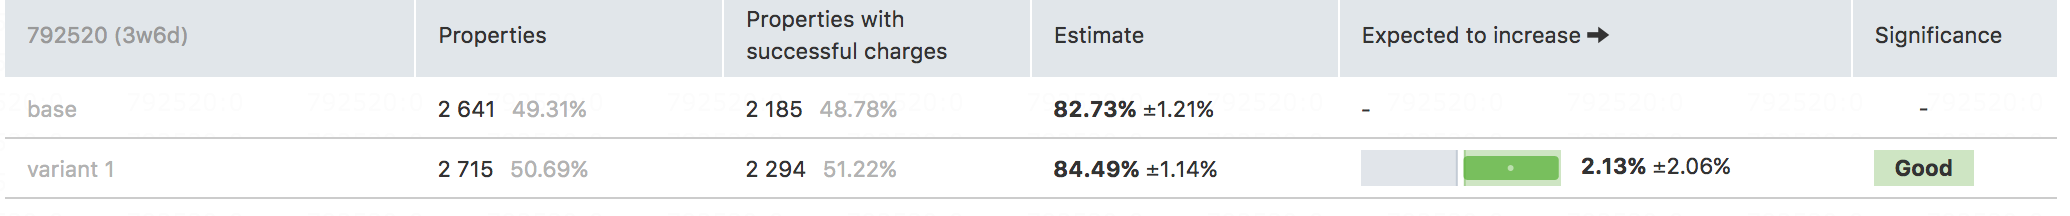

In [12]:
n_a = 2641
p_a = 0.8273

n_b = 2715
p_b = 0.8449

## Theoretical (High-Level) Approach

If you know the formula, you can simply use it and calculate instantly:

In [13]:
z = 1.65 # z-table value for 90% two-tailed confidence test

se_a = math.sqrt((p_a * (1 - p_a)) / n_a)
ci_a = z * se_a

se_b = math.sqrt((p_b * (1 - p_b)) / n_b)
ci_b = z * se_b

print("Estimate")
print("Base", '%.2f%% ±%.2f' % (p_a * 100, ci_a * 100))
print("Variant", '%.2f%% ±%.2f' % (p_b * 100, ci_b * 100))

Estimate
Base 82.73% ±1.21
Variant 84.49% ±1.15


It matches almost perfectly! (just one tiny number off due to rounding)

## Empirical (Low-Level) Approach

But is the formula actually correct though? Do you really understand what it does and how it works? Let's generate lots of random distributions (10k), and see if 90% of them are really under that interval

Estimate
Base 82.73% ±1.18
Variant 84.49% ±1.11


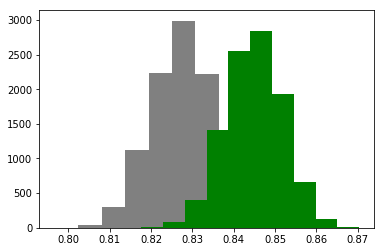

In [21]:
sampling_a = np.random.binomial(n_a, p_a, 10000) / n_a
plt.hist(sampling_a, color="grey")
ci_a = np.percentile(sampling_a, 95) - p_a

sampling_b = np.random.binomial(n_b, p_b, 10000) / n_b
plt.hist(sampling_b, color="green")
ci_b = np.percentile(sampling_b, 95) - p_b

print("Estimate")
print("Base", '%.2f%% ±%.2f' % (p_a * 100, ci_a * 100))
print("Variant", '%.2f%% ±%.2f' % (p_b * 100, ci_b * 100))

Wow, it does match, amazing! But how do you know how that binomial distribution (np.random.binomial) was generated? Can we really trust it?

## Empirical (Lowest-Level) Approach

Now I'll generate each random trial, on 10k simulations of experiments, one by one, by trowing a "biased" coin, using the most basic and lower-level code I know (it takes a while to run)

Estimate
Base 82.73% ±1.18
Variant 84.49% ±1.15


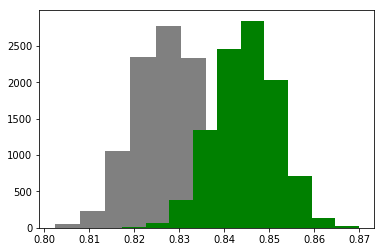

In [22]:
sampling_a = []
for i in range(0, 10000):
    sample_total = 0
    for j in range(0, n_a):
        if (random.random() <= p_a):
            sample_total += 1
    sampling_a.append(sample_total / n_a)
plt.hist(sampling_a, color="grey")
ci_a = np.percentile(sampling_a, 95) - p_a

sampling_b = []
for i in range(0, 10000):
    sample_total = 0
    for j in range(0, n_b):
        if (random.random() <= p_b):
            sample_total += 1
    sampling_b.append(sample_total / n_b)
plt.hist(sampling_b, color="green")
ci_b = np.percentile(sampling_b, 95) - p_b

print("Estimate")
print("Base", '%.2f%% ±%.2f' % (p_a * 100, ci_a * 100))
print("Variant", '%.2f%% ±%.2f' % (p_b * 100, ci_b * 100))

Close enough! I call it a day :)

# P-Value Check

In [20]:
# Example from the internet

base = pd.DataFrame({
    'variant': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    'total_successful_charges': np.array([134, 146, 104, 119, 124, 161, 107, 83, 113, 129, 97, 123])
})
variant = pd.DataFrame({
    'variant': np.array([1, 1, 1, 1, 1, 1, 1]),
    'total_successful_charges': np.array([70, 118, 101, 85, 107, 132, 94])
})
df = pd.concat([base, variant])
base = df[df['variant'] == 0]['total_successful_charges']
variant = df[df['variant'] == 1]['total_successful_charges']

print("Scipy p-value:", scipy.stats.ttest_ind(base, variant, equal_var=False).pvalue)

#### Calculation using the formula is not right yet
# null = base.mean()
# n = len(variant)
# x = variant.mean()
# s = variant.std()
# se = s / math.sqrt(n)
# t = (x - null) / se
# # t95 = 1.96
# # print("Formula CI and t-value:", (-t95, t, t95))
# pval = 1 - scipy.stats.t.cdf(np.abs(t), n-1)#*2
# print("Formula p-value:", pval)
###

def difference_of_means(df):
    base = df[df['variant_shuffled'] == 0]['total_successful_charges']
    variant = df[df['variant_shuffled'] == 1]['total_successful_charges']
    return base.mean() - variant.mean()

def one_simulated_difference(df):
    df['variant_shuffled'] = np.random.permutation(df['variant'].values)
    return difference_of_means(df) 

differences = []
for i in range(0, 1000):
    new_difference = one_simulated_difference(df)
    differences.append(new_difference)  

observed_difference = base.mean() - variant.mean()
print("observed_difference", observed_difference)
print("randomized differences[0:5]", np.array(differences)[0:5])

times_smaller_than_observed = np.count_nonzero(np.array(differences) <= -observed_difference)
times_bigger_than_observed = np.count_nonzero(np.array(differences) >= observed_difference)
print("times_smaller_than_observed * -1 =>", times_smaller_than_observed)
print("times_bigger_than_observed =>", times_bigger_than_observed)
empirical_p = (times_bigger_than_observed + times_smaller_than_observed) / 1000
print("Empirical p-value", empirical_p)

Scipy p-value: 0.07820704092145601
observed_difference 19.0
randomized differences[0:5] [ -0.67857143  12.66666667 -15.1547619  -10.17857143   1.13095238]
times_smaller_than_observed * -1 => 49
times_bigger_than_observed => 48
Empirical p-value 0.097
